Using PyTorch version: 0.4.1.post2 CUDA: False

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor



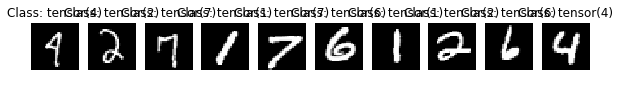

In [1]:
%matplotlib inline
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable



import math

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
#import seaborn as sns

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

#torch.manual_seed(42)
#if cuda:
#    torch.cuda.manual_seed(42)


batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

validation_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False, **kwargs)


for (X_train, y_train) in train_loader:
    print ("")
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    print ("")
    break
    
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: '+str(y_train[i]))

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 128)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), 1)
    
    # Computes the forward activation up to fc1 output. The result of
    # calling this method on a batch of images will be a matrix of size
    # (batchsize, 128) where each ROW is the fc1 feature of the corresponding
    # input image from the batch.
    def extract_fc1(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        return x

    # Computes the forward activation up to fc2 output.
    def extract_fc2(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        return x

    
model = Net()
if cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


print(model)



Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc1_drop): Dropout(p=0.2)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc2_drop): Dropout(p=0.2)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


## train, validation, test

In [3]:
def train(epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='\r')
            
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))
    


In [4]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.140019
Validation set: Average loss: 0.2050, Accuracy: 9390/10000 (93%)

Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.055877
Validation set: Average loss: 0.1388, Accuracy: 9565/10000 (95%)

Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.052214
Validation set: Average loss: 0.1069, Accuracy: 9656/10000 (96%)

Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.019383
Validation set: Average loss: 0.0950, Accuracy: 9712/10000 (97%)

Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.164503
Validation set: Average loss: 0.0866, Accuracy: 9738/10000 (97%)

Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.039688
Validation set: Average loss: 0.0799, Accuracy: 9748/10000 (97%)

Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.096821
Validation set: Average loss: 0.0727, Accuracy: 9770/10000 (97%)

Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.013104
Validation set: Average loss: 0.0743, Accuracy: 9781/10000 (97%)

Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.100250
Validation set: Averag

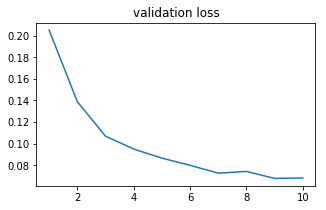

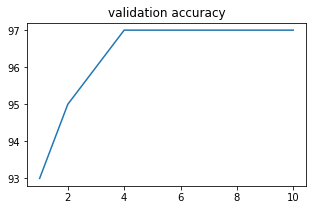

In [5]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [6]:
def extract_features(loader):
    model.eval()
    fc1 = []
    fc2 = []
    labels = []
    for data, target in loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        fc1.append(model.extract_fc1(data))
        fc2.append(model.extract_fc2(data))
        labels.append(target)
    return (torch.cat(fc1), torch.cat(fc2), torch.cat(labels))

In [7]:
(fc1, fc2, labels) = extract_features(validation_loader)
print(fc1.shape)
print(fc2.shape)
print(labels.shape)

torch.Size([10000, 128])
torch.Size([10000, 128])
torch.Size([10000])


# PCA

In [8]:

fc1 = fc1.detach().numpy()
fc2 = fc2.detach().numpy()
labels = labels.detach().numpy()
labels = labels.reshape(-1, 1)
pca1 = PCA(n_components=2)
pca1.fit(fc1)

pca2 = PCA(n_components=2)
pca2.fit(fc2)

print ("pca explained_variance_ratio")
print("")
print (pca1.explained_variance_ratio_)
print (pca2.explained_variance_ratio_)
print("")


print ("pca singular_values_")
print("")
print(pca1.singular_values_) 
print(pca2.singular_values_) 
print("")


fc1_pca = pca1.transform(fc1)
fc2_pca = pca2.transform(fc2)
print("pca transform and shape")
print("")
print (fc1.shape, fc1_pca.shape)
print (fc2.shape, fc2_pca.shape)
print("")

#pca3 = PCA(n_components=1)
#pca3.fit(labels)
#pca.fit(fc2)

pca explained_variance_ratio

[ 0.12587339  0.10312654]
[ 0.18368554  0.15573253]

pca singular_values_

[ 380.80603027  344.68475342]
[ 418.62689209  385.45999146]

pca transform and shape

(10000, 128) (10000, 2)
(10000, 128) (10000, 2)



In [9]:
import PCA_seaborn

Using PyTorch version: 0.4.1.post2 CUDA: False


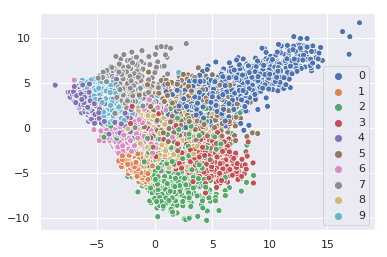

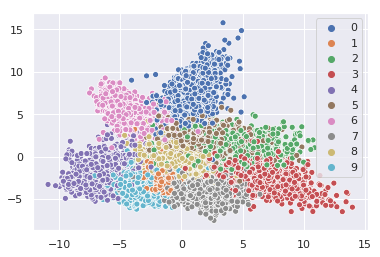

In [10]:
PCA_seaborn.PCA_seaborn(labels,fc1_pca,fc2_pca)

In [11]:
import PCA_bokeh

In [12]:
PCA_bokeh.PCA_bokeh(labels,fc2_pca)

Loading BokehJS ...

# TSNE

In [16]:
fc1_embedded = TSNE(n_components=2).fit_transform(fc1)
fc2_embedded = TSNE(n_components=2).fit_transform(fc2)

In [17]:
import TSNE_seaborn

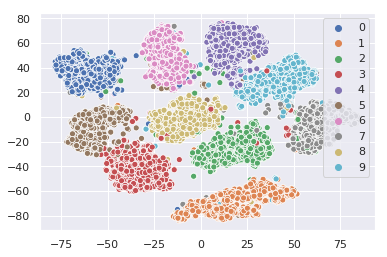

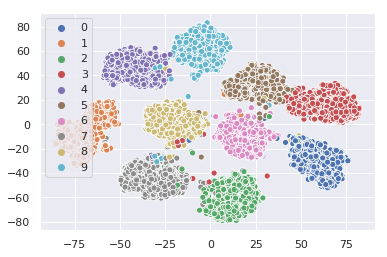

In [18]:
TSNE_seaborn.TSNE_seaborn(labels,fc1_embedded,fc2_embedded)

In [19]:
import TSNE_bokeh

In [20]:
TSNE_bokeh.TSNE_bokeh(labels,fc2_embedded)

Loading BokehJS ...